Modelling
---
It was experimented with creating separate models for Manhattan trips (both pickup and dropoff within Manhattan), but eventually all trips were trained using the same model. [LightGBM](https://lightgbm.readthedocs.io/en/latest/index.html) has been used for the prediction, though a random forest model and [AutoML](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/automl.html) were also tested. For the tuning of hyperparameters, see *hyperparameter_tuning.ipynb*.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.model_selection import learning_curve, ShuffleSplit

import lightgbm as lgb

import warnings
warnings.filterwarnings('ignore')

Read data and create dummies for the New York City boroughs. Could also create dummies for all the taxi zones, but this will lead to a data set with more data sparsity (zero or few values for many of the features).

In [2]:
df = pd.read_pickle('data/processed/gdf.pkl')
print(len(df))
print(df.columns)
df=pd.concat([df,pd.get_dummies(df[['weekday','borough_pickup','borough_dropoff']])],axis=1)
df.tail()

97481
Index(['fare_amount', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude',
       'passenger_count', 'geometry_pickup', 'zone_pickup', 'borough_pickup',
       'dropoff_longitude', 'dropoff_latitude', 'geometry_dropoff',
       'zone_dropoff', 'borough_dropoff', 'taxi_line',
       'pickup_Manhattan_South', 'dropoff_Manhattan_South',
       'pickup_Manhattan_North', 'dropoff_Manhattan_North',
       'pickup_Manhattan_MNorth', 'dropoff_Manhattan_MNorth',
       'pickup_Manhattan_MSouth', 'dropoff_Manhattan_MSouth', 'year', 'month',
       'weekday', 'hour', 'hr_sin', 'hr_cos', 'mnth_sin', 'mnth_cos',
       'eucl_distance', 'manhattan_distance', 'rotated_manhattan_distance',
       'combined_distance', 'JFK_airport', 'Newark_airport',
       'LaGuardia_airport', 'is_north', 'dist_pickup_JFK', 'dist_pickup_LGA',
       'dist_pickup_EWR', 'dist_dropoff_JFK', 'dist_dropoff_LGA',
       'dist_dropoff_EWR'],
      dtype='object')


,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,passenger_count,geometry_pickup,zone_pickup,borough_pickup,dropoff_longitude,dropoff_latitude,...,borough_dropoff_Brooklyn,borough_dropoff_EWR,borough_dropoff_East New York,borough_dropoff_Manhattan,borough_dropoff_No borogh,borough_dropoff_North New York,borough_dropoff_Queens,borough_dropoff_South New York,borough_dropoff_Staten Island,borough_dropoff_West New York
99995,9.000000,2013-09-24 07:39:00,-73.947975,40.784794,5,POINT (-73.94797515869141 40.78479385375977),East Harlem South,Manhattan,-73.964264,40.792347,...,0,0,0,1,0,0,0,0,0,0
99996,6.000000,2014-05-15 12:15:45,-73.962921,40.799107,1,POINT (-73.96292114257812 40.79910659790039),Manhattan Valley,Manhattan,-73.974174,40.786488,...,0,0,0,1,0,0,0,0,0,0
99997,5.000000,2015-02-19 17:40:43,-73.996773,40.723549,1,POINT (-73.99677276611328 40.72354888916016),Little Italy/NoLiTa,Manhattan,-73.991974,40.724724,...,0,0,0,1,0,0,0,0,0,0
99998,6.898438,2009-10-10 23:35:00,-73.983650,40.756668,4,POINT (-73.98365020751953 40.75666809082031),Times Sq/Theatre District,Manhattan,-73.982712,40.767067,...,0,0,0,1,0,0,0,0,0,0
99999,5.699219,2010-11-09 16:09:00,-73.975662,40.791653,1,POINT (-73.97566223144531 40.79165267944336),Upper West Side North,Manhattan,-73.982269,40.774967,...,0,0,0,1,0,0,0,0,0,0


## Select features

Choose which features to include in the model. According the figure from [ESL](https://web.stanford.edu/~hastie/ElemStatLearn/) below, a boosting model is quite robust to noise, hence it has not been put that much effort into removing correlated features.

<img src="fig/rf_gbm_noise.png" alt="drawing" width="500"/>

In [3]:
features = df.drop(columns=['fare_amount','weekday', 'eucl_distance', 'manhattan_distance', 'rotated_manhattan_distance',
                            'hour','borough_pickup', 'borough_dropoff',
                            'pickup_datetime', 'geometry_pickup', 'geometry_dropoff', 'zone_pickup', 'zone_dropoff', 'taxi_line', #Not included in "large calculations"
                            #'pickup_longitude', 'pickup_latitude', 'dropoff_longitude','dropoff_latitude', #Coordinates
                            #'JFK_airport', 'Newark_airport', 'LaGuardia_airport' #bool airports
                            #'dist_pickup_JFK', 'dist_pickup_LGA', 'dist_pickup_EWR', 'dist_dropoff_JFK', 'dist_dropoff_LGA', 'dist_dropoff_EWR', #Test
                             ]).columns
features

Index(['pickup_longitude', 'pickup_latitude', 'passenger_count',
       'dropoff_longitude', 'dropoff_latitude', 'pickup_Manhattan_South',
       'dropoff_Manhattan_South', 'pickup_Manhattan_North',
       'dropoff_Manhattan_North', 'pickup_Manhattan_MNorth',
       'dropoff_Manhattan_MNorth', 'pickup_Manhattan_MSouth',
       'dropoff_Manhattan_MSouth', 'year', 'month', 'hr_sin', 'hr_cos',
       'mnth_sin', 'mnth_cos', 'combined_distance', 'JFK_airport',
       'Newark_airport', 'LaGuardia_airport', 'is_north', 'dist_pickup_JFK',
       'dist_pickup_LGA', 'dist_pickup_EWR', 'dist_dropoff_JFK',
       'dist_dropoff_LGA', 'dist_dropoff_EWR', 'weekday_Friday',
       'weekday_Monday', 'weekday_Saturday', 'weekday_Sunday',
       'weekday_Thursday', 'weekday_Tuesday', 'weekday_Wednesday',
       'borough_pickup_Bronx', 'borough_pickup_Brooklyn', 'borough_pickup_EWR',
       'borough_pickup_East New York', 'borough_pickup_Manhattan',
       'borough_pickup_No borough', 'borough_pickup_Nor

## Prediction

In [4]:
X = df[features]
y = df['fare_amount']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.05, random_state=39) #Kjøre CV i stedet?
print('X_train.shape:', X_train.shape), print('X_test.shape: ', X_test.shape)
print('y_train.shape:', y_train.shape), print('y_test.shape: ', y_test.shape)

X_train.shape: (92606, 59)
X_test.shape:  (4875, 59)
y_train.shape: (92606,)
y_test.shape:  (4875,)


(None, None)

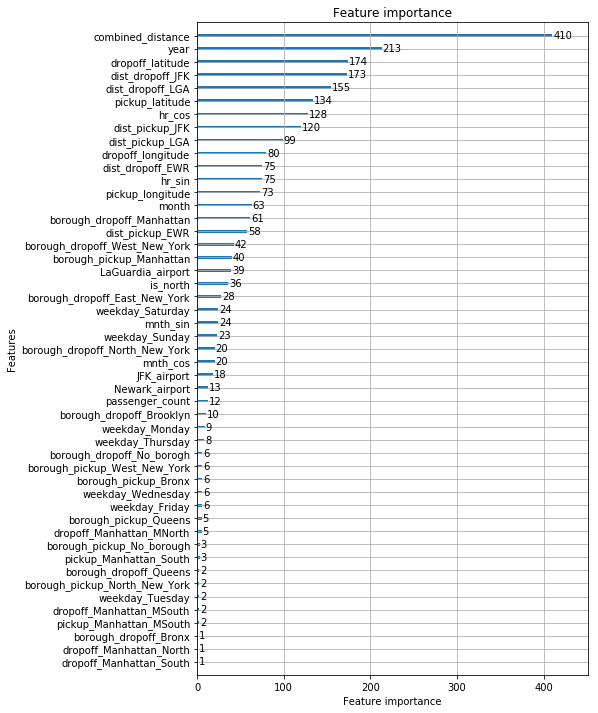

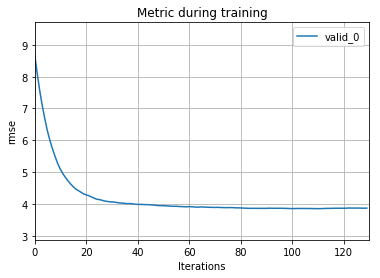

In [5]:
model = 'lgb' #rf, lgb, autoML

if model == 'rf':
    rf = RandomForestRegressor(n_estimators=5000,n_jobs=-1,
                           max_features='sqrt', min_samples_split=10)
    rf.fit(X_train, y_train)
    pred_y_train = rf.predict(X_train)
    pred_y_test = rf.predict(X_test)
    
if model == 'autoML':
    import h2o
    from h2o.automl import H2OAutoML
    h2o.init()
    X_train['fare_amount']=y_train
    X_test['fare_amount']=y_test
    x_list=list(X_train.columns)
    y_list='fare_amount'
    x_list.remove(y_list)
    train=h2o.H2OFrame(X_train) #Convert to H2OFrame
    test=h2o.H2OFrame(X_test)
    aml = H2OAutoML(max_runtime_secs = 120, stopping_metric='RMSE')
    aml.train(x = x_list, y = y_list, training_frame=train)
    print(aml.leaderboard)
    pred_y_train = aml.predict(train)
    pred_y_test = aml.predict(test)
    #Ensure same output as the other algorithms
    pred_y_train=pred_y_train.as_data_frame().values.reshape(-1)
    pred_y_test=pred_y_test.as_data_frame().values.reshape(-1)

if model == 'lgb':
    lgb_train = lgb.Dataset(X_train,y_train)
    lgb_val = lgb.Dataset(X_test, y_test)
    params = {'boosting_type': 'gbdt', 
              'objective':'regression', 
              'max_depth': 5,
              #'min_data_in_leaf': 25, 
              #'num_leaves': 200, #70, 550
              'metric': 'rmse'}
    evals_result = {}
    gbm = lgb.train(params,
                lgb_train,
                num_boost_round=1000,
                early_stopping_rounds=20,
                valid_sets=lgb_val,
                evals_result=evals_result,
                verbose_eval=False)
    pred_y_train = gbm.predict(X_train)
    pred_y_test = gbm.predict(X_test)   
    
    #Visualise:
    lgb.plot_importance(gbm,figsize=(7,12))
    lgb.plot_metric(evals_result)

### Metrics

In [6]:
mae_train=(mean_absolute_error(y_train, pred_y_train))
mae_test=(mean_absolute_error(y_test, pred_y_test))
rmse_train=(np.sqrt(mean_squared_error(y_train, pred_y_train)))
rmse_test=(np.sqrt(mean_squared_error(y_test, pred_y_test)))
y_naive=np.repeat(np.mean(y.values),y_test.shape[0])

print('Train data:\nMAE: {0:.3g}, RMSE: {1:.3g}'.format(mae_train, rmse_train))
print('Test data:\nMAE: {0:.3g}, RMSE: {1:.3g}'.format(mae_test, rmse_test))
print('\nNaive predictor:\nMAE: {0:.3g}, RMSE: {1:.3g}\n'.format(mean_absolute_error(y_test, y_naive), np.sqrt(mean_squared_error(y_test, y_naive))))

Train data:
MAE: 1.7, RMSE: 3.45
Test data:
MAE: 1.72, RMSE: 3.85

Naive predictor:
MAE: 5.88, RMSE: 9.44



Add an error column to the dataframe for easier inspection of errors:

In [7]:
df['y_pred'] = pd.Series(pred_y_test, index=y_test.index, name='y_pred')
df['error']=df['fare_amount']-df['y_pred']
df['squared_error']=np.power(df['error'],2)

print('All trips:\nMAE: {0:.3g}, RMSE: {1:.3g}\n'.format(abs(df.error).mean(), np.sqrt(df.squared_error.mean())))
print('All trips (distance > 0):\nMAE: {0:.3g}, RMSE: {1:.3g}\n'.format(abs(df[df['combined_distance']>0].error).mean(), np.sqrt(df[df['combined_distance']>0].squared_error.mean())))
print('All trips (distance == 0):\nMAE: {0:.3g}, RMSE: {1:.3g}\n'.format(abs(df[df['combined_distance']==0].error).mean(), np.sqrt(df[df['combined_distance']==0].squared_error.mean())))

print('Only Manhattan trips:\nMAE: {0:.3g}, RMSE: {1:.3g}\n'.format(abs(df[(df.borough_pickup == 'Manhattan') & (df.borough_dropoff == 'Manhattan')].error).mean(),
                                        np.sqrt(df[(df.borough_pickup == 'Manhattan') & (df.borough_dropoff == 'Manhattan')].squared_error.mean())))

print('Only outside Manhattan:\nMAE: {0:.3g}, RMSE: {1:.3g}\n'.format(abs(df[(df.borough_pickup != 'Manhattan') & (df.borough_dropoff != 'Manhattan')].error).mean(),
                                        np.sqrt(df[(df.borough_pickup != 'Manhattan') & (df.borough_dropoff != 'Manhattan')].squared_error.mean())))

print('Outside Manhattan (either pickup or dropoff or both):\nMAE: {0:.3g}, RMSE: {1:.3g}\n'.format(abs(df[(df.borough_pickup != 'Manhattan') | (df.borough_dropoff != 'Manhattan')].error).mean(),
                                        np.sqrt(df[(df.borough_pickup != 'Manhattan') & (df.borough_dropoff != 'Manhattan')].squared_error.mean())))


All trips:
MAE: 1.72, RMSE: 3.85

All trips (distance > 0):
MAE: 1.66, RMSE: 3.59

All trips (distance == 0):
MAE: 8.34, RMSE: 14.8

Only Manhattan trips:
MAE: 1.37, RMSE: 2.59

Only outside Manhattan:
MAE: 5.1, RMSE: 11.8

Outside Manhattan (either pickup or dropoff or both):
MAE: 3.89, RMSE: 11.8



### Inspection of residuals

In [8]:
def plot_residuals(y_true, y_predicted):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,8))
    ax1.plot([np.min(y_true), np.max(y_predicted)], [np.min(y_true), np.max(y_predicted)], color='r', linestyle='-', linewidth=2)
    ax1.scatter(y_true,y_predicted,alpha=0.3)
    ax1.set_xlabel('true')
    ax1.set_ylabel('predicted')
    ax2.scatter(y_true, y_true-y_predicted,alpha=0.3)
    ax2.set_xlabel('True values')
    ax2.set_ylabel('Residuals (true - predicted)')
    ax2.hlines(y=0, xmin=np.min(y_true), xmax=np.max(y_predicted), lw=2, color='red')

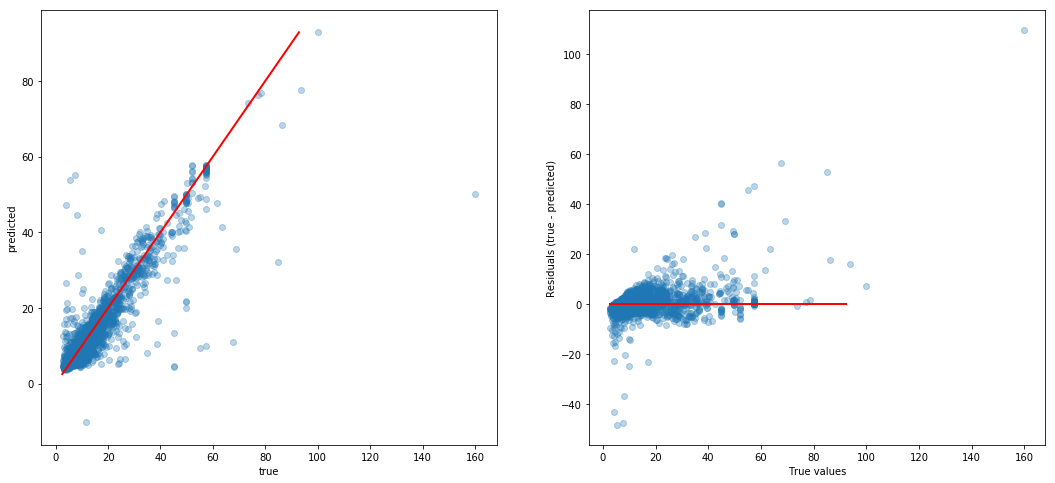

In [9]:
plot_residuals(y_true=df['fare_amount'], y_predicted=df['y_pred'])

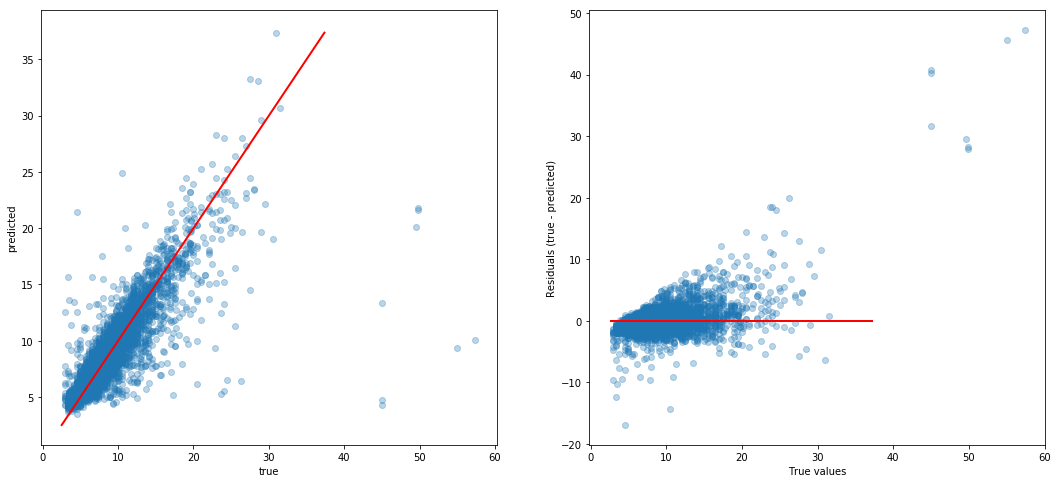

In [10]:
plot_residuals(y_true=df[(df.borough_pickup == 'Manhattan') & (df.borough_dropoff == 'Manhattan')]['fare_amount'],
               y_predicted=df[(df.borough_pickup == 'Manhattan') & (df.borough_dropoff == 'Manhattan')]['y_pred'])

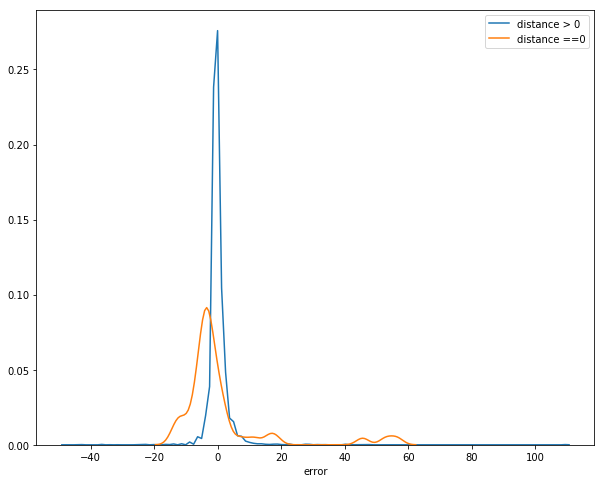

In [11]:
f, ax = plt.subplots(figsize=(10,8))
sns.distplot(df[df['eucl_distance']>0]['error'],hist=False,label='distance > 0',ax=ax)
sns.distplot(df[df['eucl_distance']==0]['error'],hist=False,label='distance ==0',ax=ax)

Text(0.5, 0, 'True - predicted')

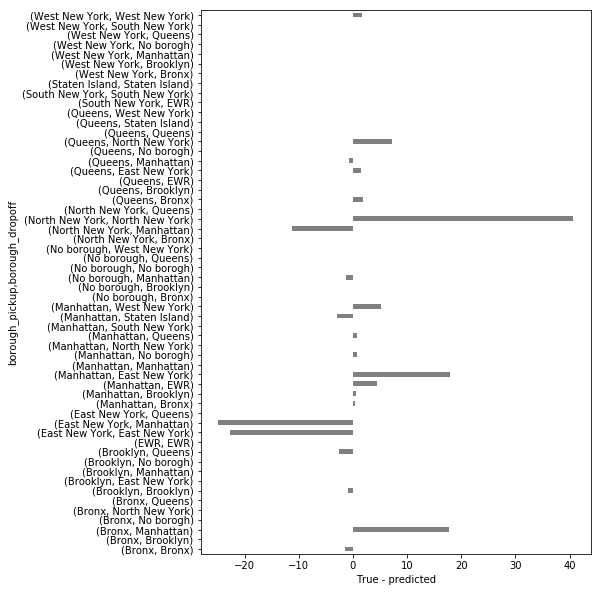

In [12]:
df.groupby(['borough_pickup','borough_dropoff']).mean()['error'].plot.barh(color='grey',figsize=(7,10))
plt.xlabel('True - predicted')

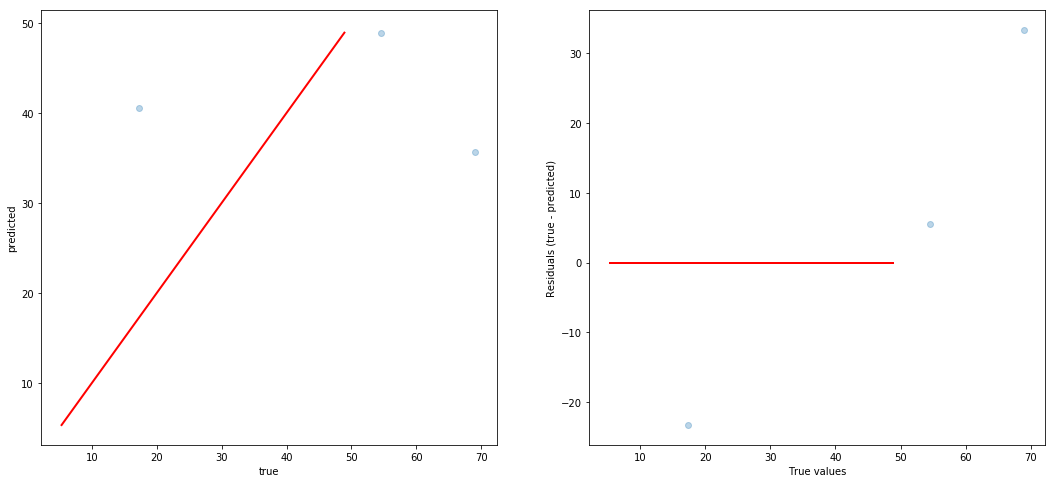

In [13]:
plot_residuals(y_true=df[(df.borough_pickup == 'Manhattan') & (df.borough_dropoff == 'West New York')]['fare_amount'],
               y_predicted=df[(df.borough_pickup == 'Manhattan') & (df.borough_dropoff == 'West New York')]['y_pred'])

In [14]:
#df[(df.pickup_latitude>41.2) | (df.dropoff_latitude>41.2)]['error'].mean()

In [15]:
#df[df['error']<-40]

More effort could be put into understanding for which taxi trips the model performs poorly. Note that the poorly predicted trips also can be studied more closely in QGIS!